In [3]:
import os, json, glob
import warnings
warnings.filterwarnings("ignore")

from typing import List, Literal
from typing_extensions import TypedDict

import os
from typing import List, Dict, Any, Optional
from dotenv import load_dotenv
from pydantic import BaseModel, Field

# LangChain 최신 버전 임포트
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.chat_models import ChatOllama
from langchain_community.vectorstores import FAISS
from langchain_community.vectorstores import Chroma 
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.documents import Document

# LangGraph 관련 임포트
from langgraph.graph import StateGraph, START, END
from langchain_community.document_loaders import JSONLoader
from langchain_community.document_loaders import DirectoryLoader, JSONLoader
from langchain_core.documents import Document
'''
1. 환경설정
'''
load_dotenv()

if not os.environ.get('OPENAI_API_KEY'):
    raise ValueError('key check....')

'''
2. 문서로드
'''
# path = r'C:\Users\pc\Downloads\59.반려견 성장 및 질병 관련 말뭉치 데이터\59.반려견 성장 및 질병 관련 말뭉치 데이터\3.개방데이터\1.데이터\Training\01.원천데이터\TS_말뭉치데이터_내과'

# docs = []

# for file_path in glob.glob(os.path.join(path, "**", "*.json"), recursive=True):
#     with open(file_path, "r", encoding="utf-8") as f:
#         data = json.load(f)

#     title = data.get("title", "") or ""
#     disease = data.get("disease", "") or ""

#     # title + disease를 page_content로 합쳐줌
#     if title and disease:
#         page_content = f"{title}\n\n{disease}"
#     else:
#         page_content = title or disease  # 하나만 있어도 그걸로

#     meta = {
#         "title": title,
#         "author": data.get("author", None),
#         "publisher": data.get("publisher", None),
#         "department": data.get("department", None),
#         "source_type": "AIHUB_data",
#     }

#     docs.append(Document(page_content=page_content, metadata=meta))

# print(f"총 {len(docs)}개 문서 로드 완료")
# print(docs[0].page_content[:300])
# print(docs[0].metadata)

'''
3. 텍스트 분할
'''
# text_splitter = RecursiveCharacterTextSplitter(
#     chunk_size=300, chunk_overlap = 50
# )
# doc_splits = text_splitter.split_documents(docs)

# 임베딩 및 VectorDB
# vectorstore = Chroma.from_documents(
#     documents=doc_splits,
#     collection_name='crag_collection',
#     embedding=OpenAIEmbeddings(model='text-embedding-3-small'),
#     persist_directory='./chroma_db' # 저장 경로
# )
# vectorstore.persist()
# print("VectorDB 저장 완료")


'\n3. 텍스트 분할\n'

In [4]:
#저장해둔 벡터DB 불러오기

embeddings = OpenAIEmbeddings(model='text-embedding-3-small')

vectorstore = Chroma(
persist_directory="./chroma_db", #저장한 경로
collection_name="pet_health_knowledge", #컬렉션 이름
embedding_function=embeddings
)


'''
4. 리트리버 설정 
'''
retriever = vectorstore.as_retriever(search_kwargs={'k':3})
print(f'VectorDB 로드 완료')

VectorDB 로드 완료


In [3]:
#검색된 문서의 관련성 평가

#GradeDocuments pydantic 모델 정의
from pydantic import BaseModel, Field
class GradeDocuments(BaseModel):
    '''문서 관련성 평가 결과를 위한 pydantic 모델'''
    binary_score: str  = Field(description="문서가 질문과 관련이 있으면 'yes, 없으면 no")


grader_llm = ChatOpenAI(model = 'gpt-4o-mini',temperature=0)
structured_grader =  grader_llm.with_structured_output(GradeDocuments) #llm이 GradeDocument에서 정의한 형식으로 출력할 수 있도록 함 


#프롬프트 템플릿 정의
grade_prompt = ChatPromptTemplate.from_messages([
    ('system','''당신은 검색된 문서가 사용자의 질문에 답변하는데 관련이 있는지 평가하는 전문가 입니다.
     
     평가기준:
     - 문서가 질문의 키워드나 의미와 연관되어 있다면 '관련있음'으로 평가
     - 답변에 도움이 될 가능성이 조금이라도 있다면 '관련있음'
     - 와전히 무관한 내용이면 '관련없음'

     엄격하게 평가하지 말고, 약간의 연관성이라도 있으면 'yes'를 반환하세요     
'''),
('human','''질문:{question}
 
 문서내용:
 {document}

 이 문서가 질문과 관련이 있습니까? 'yes' 또는 'no'로만 답하세요
 ''')
])

#프롬포트와 llm 연결
#문서 평가기 document_grader 체인 정의
document_grader = grade_prompt | structured_grader

In [ ]:
# 답변 생성 체인

prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 제공된 문맥을 바탕으로 질문에 답변하는 AI 어시스턴트입니다.
# 규칙:
# 1. 제공된 문맥 내의 정보를 우선적으로 사용하세요.
# 2. 답변은 한국어로 명확하고 구조화되게 작성하세요.
# 3. 웹 검색 결과가 포함된 경우, 해당 정보도 적절히 활용하세요.
# 4. 확실하지 않은 정보는 추측하지 마세요."""),

        ("human", """문맥(Context): {context} 질문: {question} 답변:""")
    ])

llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)


# 문서 포맷팅
def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )

# 체인 생성
rag_chain = prompt | llm | StrOutputParser()


# 체인 실행 및 결과 출력
# generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
# print(generation)

In [5]:
# 웹 검색 도구 
from langchain_community.tools.tavily_search import TavilySearchResults

web_search = TavilySearchResults(k=3) #최대 검색 결과 3개

# web_results = web_search.invoke({"query": question}) # doc 형태로 나옴 

C:\Users\pc\AppData\Local\Temp\ipykernel_26124\1233154321.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  web_search = TavilySearchResults(k=3) #최대 검색 결과 3개


상태 정의

In [ ]:
'''
RAG 상태 정의 
'''
class CGRAState(TypedDict):
    question : str
    documents : List[Document] # 검색된 문서
    filtered_documents: List[Document] # 검색된 문서 중, 관련성 평가를 통과한 문서
    web_search_needed : str   # 웹검색 여부(yes/no)
    context : str
    answer : str
    grade_results : List[str]   #각 문서의 평가 결과

노드 정의


In [39]:

# 내부 문서 검색 노드
def retrieve_node(state:CGRAState) -> dict:
    question = state['question']
    documents =  retriever.invoke(question)
    return {
        'documents':documents,
        'question' : question
    }



# 답변 생성 노드
def generate_node(state: CGRAState):
    print("\n   [GENERATE 노드] 답변 생성 중...")
    question = state["question"]
    documents = state["documents"]
    filtered_documents = state["filtered_documents"]

    # 컨텍스트 구성
    context = "\n\n---\n\n".join([doc.page_content for doc in documents])
    
    # RAG를 사용한 답변 생성
    answer = rag_chain.invoke({"context": documents, "question": question})
    print("   답변 생성 완료!")
    
    return {
        "context": context,
        "answer": answer,
        "filtered_documents": filtered_documents
    }
    


In [40]:
#문서 평가 노드

def grade_documents_node(state:CGRAState) -> dict:
    print("\n   [GRADE_DOCUMENTS 노드] 문서 관련성 평가 중...")
    question = state['question']
    documents = state['documents']

    #필터링된 문서
    filtered_docs = []
    #각 문서의 평가 결과
    grade_results = []

    for doc in documents:
        #각 문서의 관련성 평가

        score = document_grader.invoke({
            'question' : question, 'document' : doc.page_content
        })

        grade = score.binary_score.lower()

        if grade == 'yes':
            print("==== [GRADE: DOCUMENT RELEVANT] ====")
            # 관련 있는 문서를 filtered_docs 에 추가
            filtered_docs.append(doc)
            grade_results.append("relevant")

        else:
            print("==== [GRADE: DOCUMENT NOT RELEVANT] ====")
            grade_results.append("not_relevant")


    #관련 문서가 없으면 웹 검색 수행 
    if len(filtered_docs) == 0:
        web_search_needed = "Yes"
        print("   관련 문서 없음 → 웹 검색 필요!")

    else:
        web_search_needed = "No"
        print(f"  {len(filtered_docs)}개 관련 문서 확보!")

    return {
        "filtered_documents": filtered_docs,
        "web_search_needed": web_search_needed,
        "grade_results": grade_results
    }


In [41]:
#웹 검색 노드: 관련 문서가 없을 경우 실행됨

def web_search_node(state: CGRAState) -> dict:
    print("\n   [WEB SEARCH 노드] 외부 웹 검색 수행 중...")
    question = state["question"]
    filtered_docs = state["filtered_documents"]

    # 웹 검색 수행
    docs = web_search.invoke({"query": question}) #doc 형태로 나옴

    # 검색 결과를 Document 형태로 변환
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    # 기존 문서에 웹 검색 결과 추가
    filtered_docs.append(web_results)

    return {"filtered_documents": filtered_docs}



In [42]:
#조건부 엣지 함수 정의
#(if web search = yes)문서 평가 노드 → 쿼리 재작성 노드
#(if web search = no)문서 평가 노드 → 답변 생성 노드

def decide_to_generate(state: CGRAState) -> Literal["generate_node", "web_search_node"]:

    print("\n   [DECISION] 다음 단계 결정 중...")

    web_search_needed = state["web_search_needed"]

    if web_search_needed == "Yes": #웹 검색이 필요한 경우
        
        print("관련 있는 문서가 없으므로, 웹 검색으로 이동합니다. ")

        #웹 검색 노드로 라우팅
        return "web_search_node"
    
    else:
        print("관련 문서가 있으므로, 답변 생성으로 이동합니다. ")

        #답변 생성 노드로 라우팅
        return "generate_node"


        
    

그래프 생성

노드를 정의하고, 엣지를 연결해 그래프를 완성한다.

In [43]:
print("\n CRAG StateGraph 구성 및 컴파일 중...")

# StateGraph 생성
# 그래프 정의
workflow = StateGraph(CGRAState)


# 그래프에 노드 추가
workflow.add_node("retrieve_node", retrieve_node) # 리트리버 단계
workflow.add_node("grade_documents_node", grade_documents_node) # 문서 평가 단계
workflow.add_node("web_search_node", web_search_node) # 웹 검색 단계
workflow.add_node("generate_node", generate_node) # 답변 생성 단계 



 CRAG StateGraph 구성 및 컴파일 중...


**엣지 추가**

시작 → 문서 검색 노드

문서 검색 노드  → 문서 평가 노드

*조건부 엣지*
(web search = yes)문서 평가 노드 → 웹 검색 노드

(web search = no)문서 평가 노드 → 답변 생성 노드

웹 검색 노드 → 답변 생성 노드 

답변 생성 노드 → 끝




In [44]:
workflow.add_edge(START, "retrieve_node") #시작 → 문서 검색 노드
workflow.add_edge("retrieve_node", "grade_documents_node") #문서 검색 노드  → 문서 평가 노드

#조건부 엣지
workflow.add_conditional_edges(
    source = "grade_documents_node", #시작 노드
    path = decide_to_generate,      # 조건부 엣지 함수 
    path_map = {
        "generate_node": "generate_node",      # 위 함수에서 "generate" 반환 시 generate_node로 이동
        "web_search_node": "web_search_node"   # "web_search" 반환 시 web_search_node로 이동
    }
)

#웹 검색 노드 → 답변 생성 노드 
workflow.add_edge("web_search_node", "generate_node")

#답변 생성 노드 → 끝
workflow.add_edge("generate_node", END)

# 그래프 컴파일
app = workflow.compile()

In [ ]:
# !pip install -qU langchain-teddynote

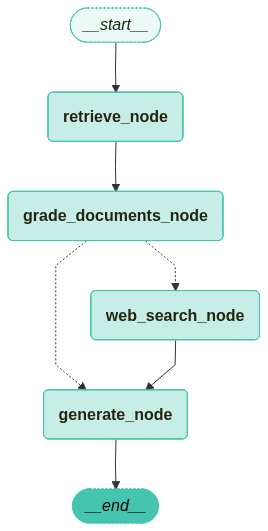

In [45]:
# 그래프 시각화
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)


그래프 실행

In [46]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(순환 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
# inputs = {
#     "question": "삼성전자가 개발한 생성형 AI 의 이름은?",
# }

test_cases = [
    {"question": "저는 3개월 된 포메라니안 컷 강아지를 기르고 있으며, 최근 며칠 동안 강아지가 심한 설사와 구토 증세를 보이며, 사료를 전혀 섭취하지 않고 있는 상황입니다. 더욱이 체중도 감소하는 추세입니다. 왜 이런 증상이 나타날까요 ?"},
    {"question": "말티즈 피부에 검은색 반점이 생는데 왜 생기는건가요 ?"}
]

# invoke_graph(app, test_cases, config)


In [47]:
for i, test in enumerate(test_cases, 1):
    print(f"\n{'━' * 70}")
    print(f" 테스트 {i}: {test['question']}")
    print(f"{'━' * 70}")
    
    # 초기 상태
    initial_state = {
        "question": test["question"],
        "documents": [],
        "filtered_documents": [],
        "web_search_needed": "No",
        "context": "",
        "answer": "",
        "grade_results": []
    }
    
    # 그래프 실행
    print("\n CRAG 워크플로우 실행 중...")
    
    final_state = None
    for output in app.stream(initial_state):
        for node_name, node_output in output.items():
            print(f"   노드 '{node_name}' 실행 완료")
        final_state = output
    
    # 결과 출력
    if "generate_node" in final_state:
        answer = final_state["generate_node"]["answer"]
    else:
        answer = "답변을 생성할 수 없습니다."
    
    print(f"\n 최종 답변:\n{answer}")


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 테스트 1: 저는 3개월 된 포메라니안 컷 강아지를 기르고 있으며, 최근 며칠 동안 강아지가 심한 설사와 구토 증세를 보이며, 사료를 전혀 섭취하지 않고 있는 상황입니다. 더욱이 체중도 감소하는 추세입니다. 왜 이런 증상이 나타날까요 ?
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

 CRAG 워크플로우 실행 중...
   노드 'retrieve_node' 실행 완료

   [GRADE_DOCUMENTS 노드] 문서 관련성 평가 중...
==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
  2개 관련 문서 확보!

   [DECISION] 다음 단계 결정 중...
관련 문서가 있으므로, 답변 생성으로 이동합니다. 
   노드 'grade_documents_node' 실행 완료

   [GENERATE 노드] 답변 생성 중...
   답변 생성 완료!
   노드 'generate_node' 실행 완료

 최종 답변:
강아지가 보이는 심한 설사와 구토, 사료 섭취 거부, 체중 감소는 여러 가지 원인으로 인해 발생할 수 있습니다. 특히 3개월 된 포메라니안과 같은 어린 강아지의 경우, 다음과 같은 가능성을 고려해야 합니다:

1. **바이러스성 감염**: 강아지 파보바이러스와 같은 바이러스성 질병이 원인일 수 있습니다. 이 질병은 주로 6주에서 6개월 사이의 강아지에서 빈번하게 발생하며, 심한 구토와 설사를 유발합니다.

2. **세균 감염**: 대장균 감염과 같은 세균성 질병도 고려해야 합니다. 특히, 이전에 언급된 사례처럼 모축의 건강 상태가 강아지에게 영향을 미칠 수 있습니다.

3. **기생충 감

AttributeError: 'function' object has no attribute 'invoke'